In [1]:
import argparse
import logging
import os
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from tqdm import tqdm

import utils
import model.net as net
import model.resnet as resnet
import model.data_loader as data_loader
from evaluate import evaluate, evaluate_kd

In [2]:
params = utils.Params('./experiments/cnn_distill/params.json')
params.cuda = torch.cuda.is_available()
random.seed(1)
torch.manual_seed(1)
if params.cuda: 
    torch.cuda.manual_seed(1)
utils.set_logger(os.path.join('./experiments/cnn_distill', 'train.log'))
logging.info("Loading the datasets...")
train_dl = data_loader.fetch_dataloader('train', params)
dev_dl = data_loader.fetch_dataloader('dev', params)
logging.info("- done.")

Loading the datasets...


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


- done.


In [3]:
# Student model : Conv-5 network
model = net.Net(params).cuda() if params.cuda else net.Net(params)
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)
metrics = net.metrics

# Teacher model : ResNet-18 network (pretrained)
teacher_model = resnet.ResNet18()
teacher_checkpoint = './experiments/base_resnet18/best.pth.tar'
teacher_model = teacher_model.cuda() if params.cuda else teacher_model
utils.load_checkpoint(teacher_checkpoint, teacher_model)

logging.info("Experiment - model version: {}".format(params.model_version))
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
logging.info("First, loading the teacher model and computing its outputs...")

Experiment - model version: cnn_distill
Starting training for 30 epoch(s)
First, loading the teacher model and computing its outputs...


In [4]:
def loss_fn_kd(outputs, labels, teacher_outputs, params):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    alpha = params.alpha
    T = params.temperature
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [5]:
best_val_acc = 0.0
# Teacher model은 학습하는게 아님. -> eval mode로 변경
teacher_model.eval()
scheduler = StepLR(optimizer, step_size=100, gamma=0.2)
val_acc_distill = []

for epoch in range(params.num_epochs):
    logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))
    model.train()
    summ = []
    loss_avg = utils.RunningAverage()
    for i, (train_batch, labels_batch) in enumerate(train_dl):
        if params.cuda:
            train_batch, labels_batch = train_batch.cuda(), labels_batch.cuda()
            # teacher model의 output 구하기
            with torch.no_grad():
                teacher_outputs = teacher_model(train_batch)
            # student model의 output 구하기
            output_batch = model(train_batch)
            # KD Loss
            loss = loss_fn_kd(output_batch, labels_batch, teacher_outputs, params)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_avg.update(loss.item())
    scheduler.step()
    val_metrics = evaluate_kd(model, dev_dl, metrics, params)     
    val_acc = val_metrics['accuracy']
    val_acc_distill.append(val_acc)
    is_best = val_acc>=best_val_acc
    #print("Epoch {}/{} | Val-Acc {:.2f}".format(epoch+1, params.num_epochs, val_acc))

Epoch 1/30
/home/sungnyun/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
- Eval metrics : accuracy: 0.644 ; loss: 0.000
Epoch 2/30
- Eval metrics : accuracy: 0.688 ; loss: 0.000
Epoch 3/30
- Eval metrics : accuracy: 0.731 ; loss: 0.000
Epoch 4/30
- Eval metrics : accuracy: 0.748 ; loss: 0.000
Epoch 5/30
- Eval metrics : accuracy: 0.765 ; loss: 0.000
Epoch 6/30
- Eval metrics : accuracy: 0.763 ; loss: 0.000
Epoch 7/30
- Eval metrics : accuracy: 0.763 ; loss: 0.000
Epoch 8/30
- Eval metrics : accuracy: 0.774 ; loss: 0.000
Epoch 9/30
- Eval metrics : accuracy: 0.782 ; loss: 0.000
Epoch 10/30
- Eval metr

In [6]:
params = utils.Params('./experiments/base_cnn/params.json')
params.cuda = True
utils.set_logger(os.path.join('./experiments/base_cnn', 'train.log'))
logging.info("Loading the datasets...")
train_dl = data_loader.fetch_dataloader('train', params)
dev_dl = data_loader.fetch_dataloader('dev', params)
logging.info("- done.")

Loading the datasets...


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


- done.


In [7]:
# Student model : Conv-5 network
model = net.Net(params).cuda() if params.cuda else net.Net(params)
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)
metrics = net.metrics

best_val_acc = 0.0
scheduler = StepLR(optimizer, step_size=100, gamma=0.2)
val_acc_nodistill = []

for epoch in range(params.num_epochs):
    logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))
    model.train()
    summ = []
    loss_avg = utils.RunningAverage()
    for i, (train_batch, labels_batch) in enumerate(train_dl):
        if params.cuda:
            train_batch, labels_batch = train_batch.cuda(), labels_batch.cuda()
            output_batch = model(train_batch)
            # CE Loss
            loss = nn.CrossEntropyLoss()(output_batch, labels_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_avg.update(loss.item())
    scheduler.step()
    val_metrics = evaluate_kd(model, dev_dl, metrics, params)     
    val_acc = val_metrics['accuracy']
    val_acc_nodistill.append(val_acc)
    is_best = val_acc>=best_val_acc

Epoch 1/30
- Eval metrics : accuracy: 0.664 ; loss: 0.000
Epoch 2/30
- Eval metrics : accuracy: 0.707 ; loss: 0.000
Epoch 3/30
- Eval metrics : accuracy: 0.736 ; loss: 0.000
Epoch 4/30
- Eval metrics : accuracy: 0.714 ; loss: 0.000
Epoch 5/30
- Eval metrics : accuracy: 0.766 ; loss: 0.000
Epoch 6/30
- Eval metrics : accuracy: 0.773 ; loss: 0.000
Epoch 7/30
- Eval metrics : accuracy: 0.765 ; loss: 0.000
Epoch 8/30
- Eval metrics : accuracy: 0.779 ; loss: 0.000
Epoch 9/30
- Eval metrics : accuracy: 0.770 ; loss: 0.000
Epoch 10/30
- Eval metrics : accuracy: 0.779 ; loss: 0.000
Epoch 11/30
- Eval metrics : accuracy: 0.782 ; loss: 0.000
Epoch 12/30
- Eval metrics : accuracy: 0.772 ; loss: 0.000
Epoch 13/30
- Eval metrics : accuracy: 0.792 ; loss: 0.000
Epoch 14/30
- Eval metrics : accuracy: 0.785 ; loss: 0.000
Epoch 15/30
- Eval metrics : accuracy: 0.771 ; loss: 0.000
Epoch 16/30
- Eval metrics : accuracy: 0.774 ; loss: 0.000
Epoch 17/30
- Eval metrics : accuracy: 0.777 ; loss: 0.000
Epoch 

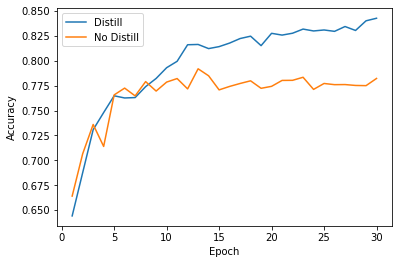

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(1, 31), val_acc_distill)
plt.plot(range(1, 31), val_acc_nodistill)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Distill', 'No Distill'])